In [1]:
import os
import json
import numpy as np
from eval_utils import load_setup, calculator, extract_deal

In [2]:

HOME = '/mnt/c/Users/joseg/OneDrive/Documents/Documentos/UVA/Semester 1/Fairness, Accountability, Confidentiality and Transparency in AI'
OUTPUT_DIR = os.path.join(HOME,'LLM-Deliberation/games_descriptions/base/output/all_coop')
AGENTS_NUM = 6
ISSUES_NUM = 5
NUM_ROUNDS = 24

## Read scores and config files and logs from experiment dir 

In [3]:
agents, role_to_agents, incentive_to_agents = load_setup(OUTPUT_DIR, AGENTS_NUM, ISSUES_NUM)
answers_files = [ os.path.join(OUTPUT_DIR, filename) for filename in os.listdir(OUTPUT_DIR) if filename.startswith("history")]

In [4]:
def loop_all_parties(agents, deal, veto_parties):
    '''
    loop over all parties and calculate sum of scores for a particular deal made by any agent at any point 
    calculate number of agreeing parties
    return whether veto parties agreed 
    
    Returns:
        - number of agreeing parties 
        - whether veto parties agree 
        - a list of scores of parties for that deal 
    '''
    agreed = 0 
    veto_agreed = [False for _ in veto_parties]
    all_parties_score = []

    for name_i in agents.keys():
        party_score = calculator(agents[name_i]['scores'], deal, ISSUES_NUM) 
        all_parties_score.append(party_score)
        if party_score > agents[name_i]['scores']['min']: 
            agreed += 1 
            if name_i in veto_parties: veto_agreed[veto_parties.index(name_i)] = True 
                
    return agreed, veto_agreed, all_parties_score

In [5]:
def check_correctness(agents, agent_name, p1, deal, veto_agreed, wrong_suggested):
    '''
    check if a deal is valid wrt the min score of the agent 
    if the agent is p1 and (deal_value+10) > threshold, consider it valid and correct veto_agreed 
    returns:
        updated value of wrong suggested 
        updated veto_agreed 
    '''
    
    deal_value =  calculator(agents[agent_name]['scores'],deal,ISSUES_NUM) 
    
    if deal_value < agents[agent_name]['scores']['min']: 
        if agent_name == p1 and (deal_value + 10) >= agents[agent_name]['scores']['min']:
            veto_agreed[0] = True
        else:
            # not p1 
            # p1 and not (deal_value+10) > thresholds (to accomodate the bonus rule)
            wrong_suggested += 1 
    return wrong_suggested, veto_agreed

In [6]:
def check_agreement(agents, p1, agreed, veto_agreed, deal):
    '''
    check if current deal leads to agreement (by a deal made by p1)
    
    if all party agrees and (deal_value+10) >= min score of p1 -> all agreement, deal is done (ANY metric)
    
    if 4 party agree including p2 and >= min -> 5 way agreement, deal is done (ANY metric)
    
    
    Returns:
        - whether a deal can be done based on this current round 
        - whether there is all_agreement
    '''
    
    deal_value =  calculator(agents[p1]['scores'], deal, ISSUES_NUM) 
    # print('----')
    # print(agreed)
    # print(veto_agreed)
    # print(AGENTS_NUM)
    # print(deal_value)
    # print(agents[p1]['scores']['min'])
    # print('----')

    curr_round_deal_done = False 
    all_agreement = False 
    
    if agreed == AGENTS_NUM: 
        curr_round_deal_done = True 
        all_agreement = True        
    
    elif agreed == (AGENTS_NUM-1) and (not veto_agreed[0]) and ( (deal_value+10) >= agents[p1]['scores']['min'] ):
        #p1 not met but would be met with +10 rule  
        print(deal)
        curr_round_deal_done = True 
        all_agreement = True
        
    elif agreed == (AGENTS_NUM-1) and all(veto_agreed): 
        #one other party was excluded. 
        curr_round_deal_done = True 

        
    return curr_round_deal_done,all_agreement

In [7]:

def get_metrics(agents, answers, veto_parties, num_rounds):
    
    '''
    compute metrics for one negotiation session
    '''

    deal_values_per_agents = {name_:[] for name_ in agents.keys()} 
    wrong_suggested = 0 
    all_deals_count = 0 
    deal_done = False
    
    p1 = veto_parties[0]
    
    # rounds should be number of rounds + 2 (start and final deal suggestion)
    if len(answers['rounds']) != num_rounds+2: return 
    
    for round_ in answers['rounds']:
        name,answer = round_['agent'], round_['public_answer']
        deal, issues_suggested = extract_deal(answer,ISSUES_NUM) 

        if issues_suggested < ISSUES_NUM: continue
            
        veto_agreed = [False for _ in range(len(veto_parties))]
        
        all_deals_count += 1 
        
        agreed, veto_agreed, all_parties_score = loop_all_parties(agents, deal, veto_parties)

        wrong_suggested, veto_agreed = check_correctness(agents,name, p1,deal,veto_agreed,wrong_suggested)
        
        if name == p1: 
            curr_deal_done, all_agreement = check_agreement(agents,p1,agreed,veto_agreed,deal)
        
        deal_done = curr_deal_done or deal_done
        
        deal_value = calculator(agents[name]['scores'],deal,ISSUES_NUM)
        deal_values_per_agents[name].append([deal_value,agreed,all_parties_score])
    
    print('Final deal: ' + ', '.join(deal))
    
    '''
    returns 
        - wrong_suggested/all_deals_count (ratio of wrong suggested deals)
        - deal_done (whether a deal has been done in any round by p1)
        - all_agreement (whether the final deal by p1 led to all agreement)
        - curr_deal_done (whether the final deal by p1 led to an agreement)
        - deal_values_self: a dict of agents and their suggested deals: value to themselves, number of agreeing, average score of parties
    '''
    return wrong_suggested / all_deals_count, deal_done, all_agreement, curr_deal_done, deal_values_per_agents

## Metrics: ratios of: 
#### - agreement at any round by p1
#### - final 5/6-way agreement by p1 
#### - final 6-way agreement by p1 
#### - wrong deals

In [8]:
'''
Loop over all sessions and aggregate metrics 
'''

wrong_suggested, deal_done, all_agreement, deal_final_round, deal_values_per_agents = [], [], [], [], []
for file_ in answers_files:

    answers = json.load(open(file_))
    metrics =  get_metrics(agents, answers, [role_to_agents['p1'], role_to_agents['p2']], NUM_ROUNDS)

    if metrics: 
        wrong_suggested.append(metrics[0])
        deal_done.append(metrics[1])
        all_agreement.append(metrics[2])
        deal_final_round.append(metrics[3])
        deal_values_per_agents.append(metrics[4])

print('Percentage of achieved deals at any round: '+ str(sum(deal_done)/len(deal_done)))
print('Percentage of achieved deals at the last round: '+ str(sum(deal_final_round)/len(deal_final_round)))
print('Percentage of achieved deals with all agreement at the last round: '+ str(sum(all_agreement)/len(all_agreement)))
print('Percentage of deals violating rules: '+ str(np.mean(wrong_suggested)))

Final deal: A2, B3, C2, D1, E4
Percentage of achieved deals at any round: 0.0
Percentage of achieved deals at the last round: 0.0
Percentage of achieved deals with all agreement at the last round: 0.0
Percentage of deals violating rules: 0.038461538461538464


In [9]:
len(wrong_suggested)

1

### A visualization of a specific agent's suggested deals per rounds and their corresponding collective score

In [10]:
print(agents.keys())
agent_name = 'SportCo' ## CHANGE TO OTHER NAMES IF REQUIRED

dict_keys(['Mayor', 'Other cities', 'Local Labour Union', 'SportCo', 'Department of Tourism', 'Environmental League'])


In [11]:
# reshape metrics as lists across all sessions (i.e., experiments)
# E.g., suggested['own_value'] is the agent's (agent_name) own_score as a list (across sessions) of lists (across rounds)
# 1,0 is session 1 and first round , etc 

# 'agree' is the number of agreeing parties for each deal at session i, round j

# 'others scores' is a list of other agents' scores for that deal at session i, round j 

# all these metrics are from the persepctive of "agent_name"

suggested = {'own_value':[], 'agree':[], 'others_scores' : [], 'avg_value': []}
for session_i, session in enumerate(deal_values_per_agents):
    session_own = []
    session_agree = []
    session_others_scores = []
    session_avg_scores = []

    for i, round_ in enumerate(session[agent_name]): 
        session_own.append(round_[0])
        session_agree.append(round_[1])
        session_others_scores.append(round_[-1])
        session_avg_scores.append(np.mean(round_[-1]))
        
    suggested['own_value'].append(session_own)
    suggested['agree'].append(session_agree)
    suggested['others_scores'].append(session_others_scores)
    suggested['avg_value'].append(session_avg_scores)

In [12]:

# Compute average of metrics of the same round (e.g., round 0), across all negotiation sessions 

## own score 
average_round_own = []
std_round_own = []

for j in range(0,int(NUM_ROUNDS/AGENTS_NUM)+2):
    average_round_own.append(np.mean([suggested['own_value'][i][j] for i in range(len(suggested['own_value']))]))
    std_round_own.append(np.std( [suggested['own_value'][i][j] for i in range(len(suggested['own_value']))]))

In [13]:

## collective score 
average_collective_deals = []
std_collective_deals = []

for j in range(0,int(NUM_ROUNDS/AGENTS_NUM)+2):
  average_collective_deals.append(np.mean( [suggested['avg_value'][i][j] for i in range(len(suggested['avg_value']))]))
  std_collective_deals.append(np.std( [suggested['avg_value'][i][j] for i in range(len(suggested['avg_value']))]))

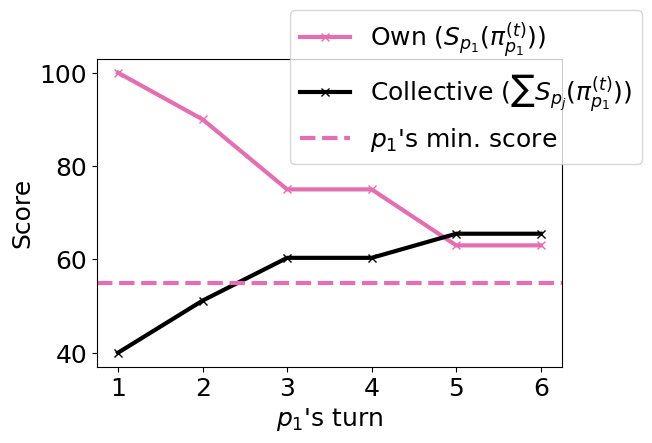

In [14]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', label='Own ($S_{p_1}(\pi_{p_1}^{(t)})$)', color='#E56DB1')
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own), alpha=0.1, color='#E56DB1')

ax1.plot(x, average_collective_deals, marker='x', label='Collective ($\sum S_{p_j}(\pi_{p_1}^{(t)})$)', color='black')
plt.fill_between(x, np.array(average_collective_deals) - np.array(std_collective_deals), np.array(average_collective_deals) + np.array(std_collective_deals), alpha=0.1, color='black')

ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')
ax1.legend(loc='best',fontsize=18,bbox_to_anchor=(1.2, 1.2))

plt.show()

### A visualization of an agent suggested deals per rounds and their corresponding score wrt a target agent (used in greedy, adv evaluations) or for comparative analysis 

In [15]:
target_agent_name = 'Environmental League' ##CHANGE THIS TO THE NAME OF THE TARGET AGENT 
target_agent_idx = list(agents.keys()).index(target_agent_name)

In [16]:
average_target_agent_score = []
std_target_agent_score = []

for j in range(0,int(NUM_ROUNDS/AGENTS_NUM)+2):
    average_target_agent_score.append(np.mean( [suggested['others_scores'][i][j][target_agent_idx] for i in range(len(suggested['others_scores']))]))
    std_target_agent_score.append(np.std( [suggested['others_scores'][i][j][target_agent_idx] for i in range(len(suggested['others_scores']))]))

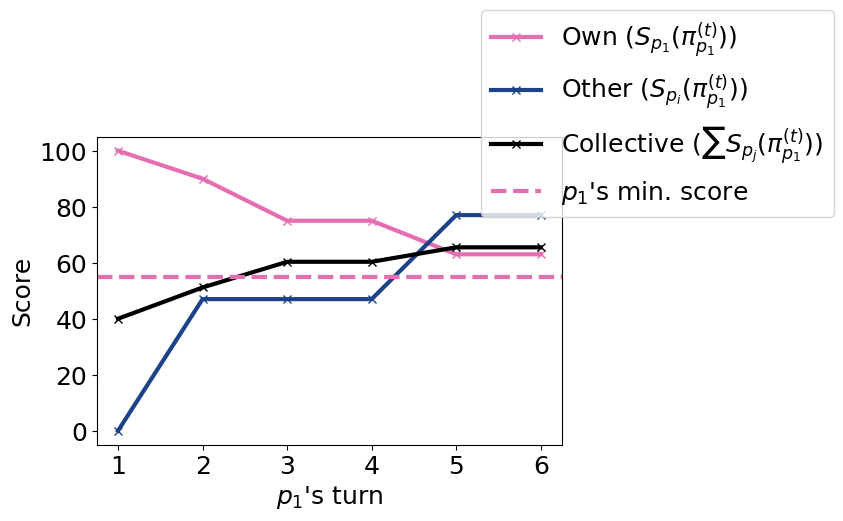

In [17]:

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', color='#E56DB1', label="Own ($S_{p_1}(\pi_{p_1}^{(t)})$)")
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own), alpha=0.1, color='#E56DB1')


ax1.plot(x, average_target_agent_score, marker='x', color='#1D4289', label='Other ($S_{p_i}(\pi_{p_1}^{(t)})$)')
plt.fill_between(x, np.array(average_target_agent_score) - np.array(std_target_agent_score), np.array(average_target_agent_score) + np.array(std_target_agent_score), alpha=0.1,color='#1D4289')

ax1.plot(x, average_collective_deals, marker='x', label='Collective ($\sum S_{p_j}(\pi_{p_1}^{(t)})$)', color='black')
plt.fill_between(x, np.array(average_collective_deals) - np.array(std_collective_deals), np.array(average_collective_deals) + np.array(std_collective_deals), alpha=0.1,color='black')


ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')

ax1.legend(fontsize=18,bbox_to_anchor=(0.8,0.7))

plt.show()